# GoCa tutorial
This notebook is a tutorial and example of how to use the GoCa model to simulate and evaluate the assembly of protein complexes.

Here, we simulate the assembly of a homotrimeric protein complex, the mammalian tumor associated antigen UK114 (PDB: [1NQ3](https://www.rcsb.org/structure/1nq3)). The following figure shows the crystal structure of the protein in a cartoon representation. We will use this crystal structure as the native conformation for our simulations.  
<img src="https://cdn.rcsb.org/images/structures/1nq3_assembly-1.jpeg" alt="drawing" width="250"/>

The tutorial / application example consists of five steps:
- Structure download and preparation
- Generation of the GoCa model simulation files
- Simulation with [Gromacs](https://www.gromacs.org/)
- Trajectory processing
- Simulation Analysis
- Visualization of the trajectory with VMD

### Prerequisites:
- Gromacs (see [here](https://manual.gromacs.org/current/install-guide/index.html) for installation instructions, any newer version (>=2018) should work)
- `tleap` from AmberTools (see [here](https://ambermd.org/AmberTools.php) for installation instructions; we use this to add missing hydrogen atoms. In comparison to Amber, AmberTools is free. Alternatively, you can use any other tool to add missing hydrogen atoms to a protein structure.)
- `g++` and `make` (for building the GoCa program binary)
- `wget` for downloading files
- `python3` for trajectory analysis
- `VMD` to visualize the trajectories (other visualization tools can be used alternatively)
- **Downloaded *GoCa* repository (where this tutorial is part of)**
- **Install *GoCa* (please follow instructions in the [README](https://github.com/ZachariasLab/GoCa/blob/main/README.md) on github)**

## 0. File tree setup

The next cell contains the path to the root directory of the GoCa repository, the file path `fp`. If you execute this notebook in the default subdirectory of the repository, the root directory will be in `..`, if you move this notebook to a new location, you should adapt the path in the variable `fp`. In this case, also make sure that you copy the other necessary files with the notebook (`minimization.mdp`,`simulation.mdp`, `GoCa-config.ini` and eventually `simulation.vmd`).

In [21]:
fp = '..'

We create a new directory to store all files, which are generated in the course of this tutorial. By deleting this directory you can easily restart the tutorial. The `output-worked` directory already contains all the files which will be generated during this tutorial. If you get stuck at any step, you can look there for the expected output.

In [22]:
output = 'output'
!mkdir {output}

mkdir: cannot create directory ‘output’: File exists


## 1. Structure preparation
Now that everything is set up, we can start the first part of the tutorial. 

First, we download the input structure file from the PDB. Moreover, using the tool `sed`, we extract the first three chains (A, B, and C) from the `.pdb` file and remove all meta information. The original structure contains two copies of the protein trimer, therefore we want to extract only the first three chains.

In [23]:
!wget -O {output}/protein.pdb https://files.rcsb.org/download/1NQ3.pdb
!sed -i '/^ATOM.*[A-Z]\s[ABC]\s/!d' {output}/protein.pdb

--2024-02-12 10:57:39--  https://files.rcsb.org/download/1NQ3.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.159.157
Connecting to files.rcsb.org (files.rcsb.org)|128.6.159.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘output/protein.pdb’

output/protein.pdb      [   <=>              ] 524,76K  1,00MB/s    in 0,5s    

2024-02-12 10:57:40 (1,00 MB/s) - ‘output/protein.pdb’ saved [537354]



The first two chains are missing a serine amino acid at the beginning, while the third chain is missing an alanine at the end. For topology merging, we want all chains to have the same sequence. Therefore, for simplicity, we just remove the last amino acid from the first two chains and the first residue from the third chain.

In [24]:
!sed -i '/ALA A 135/d' {output}/protein.pdb
!sed -i '/ALA B 135/d' {output}/protein.pdb
!sed -i '/SER C   2/d' {output}/protein.pdb

The downloaded structure file does not contain hydrogen atoms. Since the *GoCa* programs assume that input structures contain hydrogens by default, we add hydrogens using the `hydrogenize.sh` script. This script is part of the *GoCa* repository and uses the `tleap` program from the AmberTools package.

In [25]:
!bash ./{fp}/hydrogenize.sh {output}/protein.pdb {output}/protein-h.pdb {output}/tleap.log
!rm leap.log -v

removed 'leap.log'


The protein structure is now ready to be processed by the *GoCa* program.

## 2. Generation of the CoCa model simulation files
Before running the *GoCa* program, we can change various configuration parameters. However, the default configuration is a good start and sufficient for our example. We will use the configuration file included in the tutorial directory.  
After the configuration file is prepared, we can finally run the *GoCa* program to generate the coarse-grained topology and coordinate file:

In [26]:
!./{fp}/GoCa GoCa-config.ini

1. Generating coarse grained model
Info: Reading protein file: output/protein-h.pdb
Info: Got a total of 396 Cα-atoms from 5916 atoms in 3 chain(s)
2. Calculating native contacts
Info: Got 1 merged chain from originally 3 chains
Chain 1: SLVRRIISTAKAPAAIGPYSQAVLVDRTIYISGQLGMDPASGQLVPGGVVEEAKQALTNIGEILKAAGCDFTNVVKATVLLADINDFSAVNDVYKQYFQSSFPARAAYQVAALPKGGRVEIEAIAVQGPLTT
Chain 2: SLVRRIISTAKAPAAIGPYSQAVLVDRTIYISGQLGMDPASGQLVPGGVVEEAKQALTNIGEILKAAGCDFTNVVKATVLLADINDFSAVNDVYKQYFQSSFPARAAYQVAALPKGGRVEIEAIAVQGPLTT
Chain 3: SLVRRIISTAKAPAAIGPYSQAVLVDRTIYISGQLGMDPASGQLVPGGVVEEAKQALTNIGEILKAAGCDFTNVVKATVLLADINDFSAVNDVYKQYFQSSFPARAAYQVAALPKGGRVEIEAIAVQGPLTT
3. Writing topology file to output/output.top
4. Writing coordinate file to output/output.gro


The output directory contains a topology file (`.top`) and a structure file (`.gro`) now.  
The topology file describes the interactions within our protein complex based on the native conformation we provided. We can use this custom force field for our simulation.  
The coordinate file also contains the native conformation. However, we don't want our simulation to start with the assembled structure. Instead, we want to start with a disassembled configuration and simulate the assembly process. Therefore, we use a coordinate file with randomly placed homomeric protein subunits. To generate such a configuration, we first extract a single chain from the coordinate file (using the residue index of each coarse-grained bead):

In [27]:
with open(f'{output}/output-single.gro', 'w') as output_file:
    with open(f'{output}/output.gro', 'r') as input_file:
        lines = input_file.readlines()
        lines = [line for i, line in enumerate(lines) if i < 2 or i > len(lines) - 2 or int(line[:5]) == i - 1]
        lines[1] = f'{len(lines) - 3}\n'
        output_file.write(''.join(lines))

We use the GROMACS command `gmx insert-molecules` to generate the random configuration with three subunits and the same box size as in our assembled coarse-grained structure file:

In [28]:
box_size = ' '.join(lines[-1].split())
!gmx insert-molecules -ci {output}/output-single.gro -o {output}/random.gro \
                      -box {box_size} -nmol 3 -try 100 -seed 4242

          :-) GROMACS - gmx insert-molecules, 2021.5-plumed-2.7.4 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff         

Now, everything is prepared to start the Gromacs simulation.

Please note that we set explicitly set the seed for the randomized placement of the molecules. Thereby, we ensure reproducibility. For actual application, this might not be desired.

## 3. Simulation

Since we have randomly placed the protein subunits in the simulation box, it is safer to do an energy minimization first. This should be quick:

In [29]:
!gmx grompp -f minimization.mdp -p {output}/output.top -c {output}/random.gro \
            -o {output}/minimization.tpr -po {output}/minimization.mdp
!gmx mdrun -deffnm {output}/minimization -ntmpi 1 -reprod

               :-) GROMACS - gmx grompp, 2021.5-plumed-2.7.4 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Te

Then we run the assembly simulation. This may take a few minutes, depending on your hardware.

In [30]:
!gmx grompp -f simulation.mdp -p {output}/output.top -c {output}/minimization.gro \
            -o {output}/simulation.tpr -po {output}/simulation.mdp
!gmx mdrun -deffnm {output}/simulation -ntmpi 1 -reprod

               :-) GROMACS - gmx grompp, 2021.5-plumed-2.7.4 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Te

After the simulation finished, we continue with the post-processing of the trajectories. 

Please note that we used the `-reprod` flag here. Thereby, we improve reproducibility of the simulations in this tutorial. In addition, we fixed the random seeds in the prepared input file `simulation.mdp`. For actual applications, we would refrain from doing that.

## 4. Trajectory Processing
In the simulation we use periodic boundary conditions (PBC). Because these can make the analysis complicated, we use the Gromacs tool `gmx trjconv` with the option `-pbc cluster`. As a result, we obtain a trajectory which allows to observe the assembly of the protein complex.

In [31]:
!echo -e 'System System System ' | \
gmx trjconv -f {output}/simulation.xtc -s {output}/simulation.tpr -o {output}/simulationNoPBC.xtc \
            -center -pbc cluster

               :-) GROMACS - gmx trjconv, 2021.5-plumed-2.7.4 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clusteri

Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clusteri

Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clusteri

Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clusteri

Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clusteri

Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clusteri

Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clusteri

Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clusteri

Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clusteri

Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clusteri

Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clusteri

Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clustering iteration 3 of 3...
Clusteri

Due to the `-pbc cluster` option, jumps of individual, unassembled chains may occur between trajectory frames. However, this option ensures that already assembled parts of the protein complex are never separated by the periodic boundary conditions. Since we are more interested in the assembly of the complex than in the trajectories of the individual chains, this is not a problem.

## 5. Simulation Analysis

In the last part of this tutorial we will continue with the analysis of our simulation.  
We will use some Python functions provided with the *GoCa* repository to extract different properties from the simulation trajectory.  
We start by importing some Python packages:

In [32]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(f'{fp}/evaluation')
import analysis as goca_analysis
import gromacs_analysis as goca_gmx_analysis

We load the processed trajectory, together with the coarse-grained topology and the structure of the native conformation into a `goca_gmx_analysis.GromacsTrajectory` object, which inherits from the `goca_analysis.Trajectory` class.

In [33]:
trajectory = goca_gmx_analysis.GromacsTrajectory(
    f'{output}/simulationNoPBC.xtc',
    f'{output}/output.gro',
    f'{output}/output.top'
)

/home/paq/anaconda3/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (LEU, SER)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/paq/anaconda3/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, LEU)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/paq/anaconda3/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ARG, VAL)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/paq/anaconda3/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, ARG)
  warnings.warn("WARNING: two consecutive residues with same number (%s, 

### RMSD
We start with the analysis of the [RMSD](https://en.wikipedia.org/wiki/Root-mean-square_deviation_of_atomic_positions) of the individual chains and of the entire complex. We iterate over all frames in the trajectory and calculate the RMSD from the native conformation:

In [34]:
chains_indices = [trajectory.get_chain_start_stop_indices(i) for i in range(3)] # Individual chains
chains_indices += [(0, trajectory.size())] # Complete complex
rmsd = np.empty((len(trajectory.get_trajectory()), len(chains_indices)))
for i, frame in enumerate(trajectory.get_trajectory()):
    rmsd[i] = [
        goca_analysis.aligned_rmsd(
            frame[cids[0]:cids[1]],
            trajectory.get_initial_conformation()[cids[0]:cids[1]]
        ) for cids in chains_indices
    ]

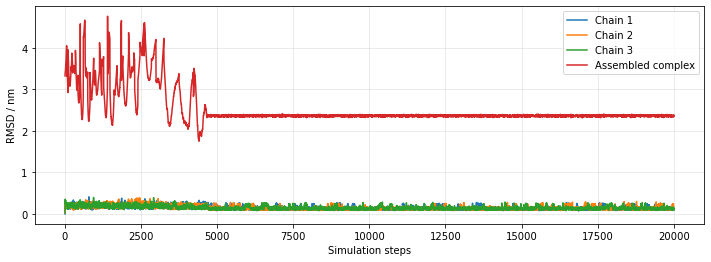

In [35]:
plt.figure(figsize=(12, 4))
plt.plot(rmsd)
plt.legend(['Chain 1', 'Chain 2', 'Chain 3', 'Assembled complex'])
plt.ylabel('RMSD / nm')
plt.xlabel('Simulation steps')
plt.grid(alpha=0.3)
plt.show()

Since we start with a configuration of folded but disassembled chains, the RMSD of each chain is close to zero at the beginning of the trajectory. Furthermore, the RMSDs of the chains remain close to zero, i.e. they remain folded throughout the simulations. In contrast, the RMSD of the entire complex is not close to zero at the beginning of the simulation. However, during the simulation, the RMSD of the protein complex may eventually drop to a value close to zero. This indicates successful assembly of the complex. 

**However**, there is another possible scenario: Since GoCa allows for free permutation of identical chains, the complex may also assemble in a different a different order than in the crystal structure. In this case, the RMSD of the complex with respect to the crystal structure, will never be close to zero. Let's continue our analysis to verify one or the other case.

The following image, included from the `output-worked` directory, shows what the result might look like. Here, the complex has assembled in the same arrangement as in the reference structure.  
<img src="output-worked/RMSD.png" alt="RMSD" width="740px"/>

### Fraction of native contacts
Furthermore, we can analyze the fraction of native contacts within and between the protein chains. Here, native contacts correspond to all native pairs in the topology file as derived from the native conformation. A logistic sigmoid cutoff is used to determine whether two coarse-grained beads form a native contact or not.

In [36]:
fnc_intramolecular = trajectory.get_fraction_of_native_contacts_inside()
fnc_intermolecular = trajectory.get_fraction_of_native_contacts_between()

We plot both fraction of native contact evaluations in the same diagram. Since the topology contains intermolecular native pairs between all possible chain pair combinations and the final assembly contains only three chain pair contacts, we must multiply the intermolecular fraction of native contacts by a factor of three:

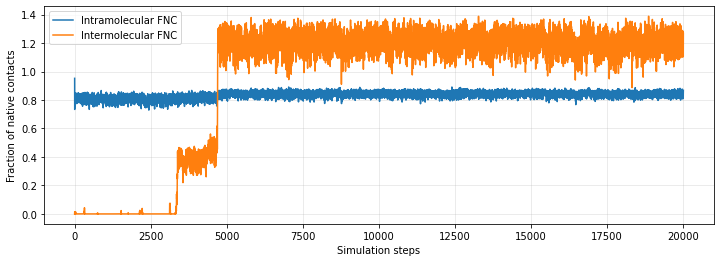

In [37]:
plt.figure(figsize=(12, 4))
plt.plot(fnc_intramolecular, label="Intramolecular FNC")
plt.plot(fnc_intermolecular * 3, label="Intermolecular FNC")
plt.ylabel('Fraction of native contacts')
plt.xlabel('Simulation steps')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

This graph complements the findings of the previous graph. The intramolecular FNC remains relatively constant throughout the trajectory (except for small fluctuations). In contrast, the intermolecular FNC starts at about zero. At some point, it suddenly increases and then remains relatively constant at that level for a while. Finally, it increases again and remains at this level (again with some fluctuations) until the end of the simulation. The intermolecular FNC indicates the two assembly steps of our trimeric protein complex: first, two subunits assemble into a dimer. Second, the dimer binds to the last free chain to form the final trimeric structure. *(If this does not happen in your simulation, you were quite unlucky. You may extend the simulation, or restart the simulation completely.)*  

The following image, included from the `output-worked` directory, shows what the result might look like.  
<img src="output-worked/FNC.png" alt="Fraction of native contacts" width="740px"/>

### Assembly state clustering
Finally, we can cluster all the trajectory frames into different assembly states. First, we transform each trajectory frame into a graph object. The nodes of the graph objects correspond to the chains of the protein complex. If two chains are bound, their nodes are connected by an edge. Afterwards, these graphs are used for the clustering of the assembly path.

In [38]:
graphs = trajectory.get_chain_graph(logging=False)
clusters, labels = trajectory.get_chain_formations(graphs, filtering=100)

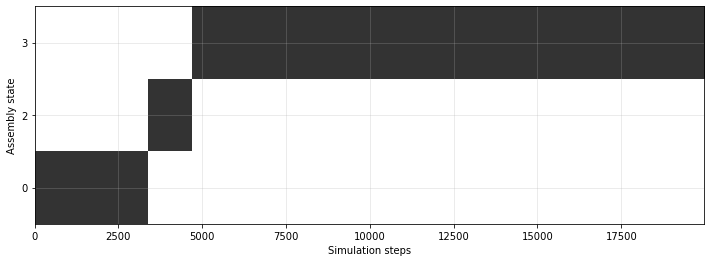

In [39]:
plt.figure(figsize=(12, 4))
plt.imshow(clusters, interpolation='nearest', aspect='auto', cmap='Greys', alpha = 0.8)
plt.yticks(np.arange(0, len(labels)), labels)
plt.ylabel('Assembly state')
plt.xlabel('Simulation steps')
plt.grid(alpha=0.3)
plt.show()

This diagram shows, similar to the previous plot, the assembly path of the three protein chains. In the beginning, all chains are unbound (state 0). After a while, two chains form a dimer (state 2). Finally, the trimeric complex is formed (state 3). These results should be very consistent with the results above. *(If the complete assembly does not happen in your simulation, you were quite unlucky. You may extend the simulation, or restart the simulation completely.)*  

The following image, included from the `output-worked` directory, shows what the result might look like.  
<img src="output-worked/assembly_states.png" alt="Assembly states" width="740px"/>

## 6. Visualization of the trajectory with VMD

To visualize the trajectory better, we convert the starting structure to the pdb format. In contrast to the gro format, it contains the information about different chains:


In [40]:
!echo "System " | gmx trjconv -s {output}/simulation.tpr -f {output}/minimization.gro -o {output}/start.pdb

               :-) GROMACS - gmx trjconv, 2021.5-plumed-2.7.4 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

In case you have installed VMD, you may visualize the trajectory, executing `vmd -e simulation.vmd`. 
Otherwise, you may use any other visualization tool to visualize the structure file `output/start.pdb` and the trajectory `output/simulationNoPBC.xtc`.